# NLP for BBC News


## Import Library


In [137]:
import pandas as pd
import nltk, os, re, string
import zipfile

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.layers import Input, LSTM, Bidirectional, SpatialDropout1D, Dropout, Flatten, Dense, Embedding, BatchNormalization
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer, text_to_word_sequence

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk import pos_tag

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to C:\Users\asus.LAPTOP-
[nltk_data]     P9TBK6TS.000\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\asus.LAPTOP-
[nltk_data]     P9TBK6TS.000\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\asus.LAPTOP-
[nltk_data]     P9TBK6TS.000\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to C:\Users
[nltk_data]     \asus.LAPTOP-P9TBK6TS.000\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Download dataset from Kaggle

## Load dataset


In [138]:
data = pd.read_csv('pemilu (3).csv', sep=';')
data.head()

,created_at,id_str,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url
0,Sun Jan 07 23:55:32 +0000 2024,1744145777877037180,jiahahaha prabowo dicebokin bot #DebatCapres,0,0,0,1,in,1431142289884135428,1744145777877037180,hochidubu,https://twitter.com/hochidubu/status/174414577...
1,Sun Jan 07 23:54:50 +0000 2024,1744145600130711777,Biar masyarakat yg menilai ya pak. #02KubuArog...,0,0,0,2,in,1723961822829809664,1744145600130711777,archie99634,https://twitter.com/archie99634/status/1744145...
2,Sun Jan 07 23:54:32 +0000 2024,1744145523194638522,@erlanishere @Gerindra Dan diungkap di #DebatC...,0,0,0,0,in,604333557,1744004360651292983,rektrektrekt123,https://twitter.com/rektrektrekt123/status/174...
3,Sun Jan 07 23:53:34 +0000 2024,1744145279849542072,Jubir TKD Jatim: Prabowo akan Memperkuat Siste...,0,0,0,0,in,21287066,1744145279849542072,beritajatimcom,https://twitter.com/beritajatimcom/status/1744...
4,Sun Jan 07 23:52:51 +0000 2024,1744145100048077090,@RadioElshinta ANIES ROCKS DEBAT CAPRES !! #D...,0,0,1,3,en,129750289,1743960193225150558,ZAEffendy,https://twitter.com/ZAEffendy/status/174414510...


In [139]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 565 entries, 0 to 564
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   created_at           565 non-null    object
 1   id_str               565 non-null    int64 
 2   full_text            565 non-null    object
 3   quote_count          565 non-null    int64 
 4   reply_count          565 non-null    int64 
 5   retweet_count        565 non-null    int64 
 6   favorite_count       565 non-null    int64 
 7   lang                 565 non-null    object
 8   user_id_str          565 non-null    int64 
 9   conversation_id_str  565 non-null    int64 
 10  username             565 non-null    object
 11  tweet_url            565 non-null    object
dtypes: int64(7), object(5)
memory usage: 53.1+ KB


In [140]:
data.shape

(565, 12)

In [141]:
data.columns

Index(['created_at', 'id_str', 'full_text', 'quote_count', 'reply_count',
       'retweet_count', 'favorite_count', 'lang', 'user_id_str',
       'conversation_id_str', 'username', 'tweet_url'],
      dtype='object')

In [142]:
data_new = data[['created_at', 'username', 'full_text']]

data_new.head(10)

,created_at,username,full_text
0,Sun Jan 07 23:55:32 +0000 2024,hochidubu,jiahahaha prabowo dicebokin bot #DebatCapres
1,Sun Jan 07 23:54:50 +0000 2024,archie99634,Biar masyarakat yg menilai ya pak. #02KubuArog...
2,Sun Jan 07 23:54:32 +0000 2024,rektrektrekt123,@erlanishere @Gerindra Dan diungkap di #DebatC...
3,Sun Jan 07 23:53:34 +0000 2024,beritajatimcom,Jubir TKD Jatim: Prabowo akan Memperkuat Siste...
4,Sun Jan 07 23:52:51 +0000 2024,ZAEffendy,@RadioElshinta ANIES ROCKS DEBAT CAPRES !! #D...
5,Sun Jan 07 23:52:16 +0000 2024,ShireenEsa90311,"Israel, claims humanity and is saddened by the..."
6,Sun Jan 07 23:52:05 +0000 2024,AminudinRashya,Tetap semangat Jepang Barat Korea Fansite Indo...
7,Sun Jan 07 23:51:07 +0000 2024,ceasarru,Yang mendesak El Gemoy itu baru satu orang saj...
8,Sun Jan 07 23:50:39 +0000 2024,radenimanuel1,Itu pendukung pak anies apa ga ada yang hilang...
9,Sun Jan 07 23:50:06 +0000 2024,maul_af,Ada yang pernah ngerasain seperti ini? 😭 - A ...


## Cleansing data

In [143]:
from nlp_id.lemmatizer import Lemmatizer

def clean_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

lemmatizer = Lemmatizer()

def lemmatize_text(text):
    return lemmatizer.lemmatize(text)

def remove_numbers(text):
    return re.sub('[0-9]+', '', text)

def remove_stopwords(text):
    stop_words = set(stopwords.words('indonesian'))
    return ' '.join([word for word in nltk.word_tokenize(text) if word.lower() not in stop_words])

data_new['full_text'] = data_new['full_text'].apply(lambda x: x.lower())

data_new['full_text'] = data_new['full_text'].apply(clean_punctuation)

data_new['full_text'] = data_new['full_text'].apply(lemmatize_text)

data_new['full_text'] = data_new['full_text'].apply(remove_numbers)

data_new['full_text'] = data_new['full_text'].apply(remove_stopwords)

C:\Users\asus.LAPTOP-P9TBK6TS.000\AppData\Local\Temp\ipykernel_29984\2622501197.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new['full_text'] = data_new['full_text'].apply(lambda x: x.lower())
C:\Users\asus.LAPTOP-P9TBK6TS.000\AppData\Local\Temp\ipykernel_29984\2622501197.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new['full_text'] = data_new['full_text'].apply(clean_punctuation)
C:\Users\asus.LAPTOP-P9TBK6TS.000\AppData\Local\Temp\ipykernel_29984\2622501197.py:22: SettingWithCopy

C:\Users\asus.LAPTOP-P9TBK6TS.000\AppData\Local\Temp\ipykernel_29984\2622501197.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new['full_text'] = data_new['full_text'].apply(remove_stopwords)


In [144]:
data_new.head(10)

,created_at,username,full_text
0,Sun Jan 07 23:55:32 +0000 2024,hochidubu,jiahahaha prabowo dicebokin bot debatcapres
1,Sun Jan 07 23:54:50 +0000 2024,archie99634,biar masyarakat yg nilai ya kubuarogan debatca...
2,Sun Jan 07 23:54:32 +0000 2024,rektrektrekt123,erlanishere gerindra debatcapres tonton jagat
3,Sun Jan 07 23:53:34 +0000 2024,beritajatimcom,jubir tkd jatim prabowo kuat sistem militer in...
4,Sun Jan 07 23:52:51 +0000 2024,ZAEffendy,radioelshinta anies rocks debat capres debatca...
5,Sun Jan 07 23:52:16 +0000 2024,ShireenEsa90311,israel claims humanity and is saddened by the ...
6,Sun Jan 07 23:52:05 +0000 2024,AminudinRashya,semangat jepang barat korea fansite indonesia ...
7,Sun Jan 07 23:51:07 +0000 2024,ceasarru,desak el gemoy orang amp beliau males salam ma...
8,Sun Jan 07 23:50:39 +0000 2024,radenimanuel1,dukung anies ga hilang respect gara gara nyeng...
9,Sun Jan 07 23:50:06 +0000 2024,maul_af,ngerasain a thread meme debatcapres paslon blu...


## Data Preparation

In [145]:
df_slang = pd.read_csv('kamus-alay\colloquial-indonesian-lexicon.csv')  # Ganti 'daftar_slang.csv' dengan nama file CSV Anda

# Fungsi untuk mengubah kata slang menjadi kata formal
def replace_slang(text):
    words = text.split()
    for i in range(len(words)):
        slang_word = df_slang[df_slang['slang'] == words[i]]
        if not slang_word.empty:
            words[i] = slang_word['formal'].values[0]
    return ' '.join(words)

In [146]:
data_new['full_text'] = data_new['full_text'].apply(replace_slang)

data_new.head(10)

C:\Users\asus.LAPTOP-P9TBK6TS.000\AppData\Local\Temp\ipykernel_29984\3578364852.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new['full_text'] = data_new['full_text'].apply(replace_slang)


,created_at,username,full_text
0,Sun Jan 07 23:55:32 +0000 2024,hochidubu,jiahahaha prabowo dicebokin bot debatcapres
1,Sun Jan 07 23:54:50 +0000 2024,archie99634,biar masyarakat yang nilai ya kubuarogan debat...
2,Sun Jan 07 23:54:32 +0000 2024,rektrektrekt123,erlanishere gerindra debatcapres tonton jagat
3,Sun Jan 07 23:53:34 +0000 2024,beritajatimcom,jubir tkd jatim prabowo kuat sistem militer in...
4,Sun Jan 07 23:52:51 +0000 2024,ZAEffendy,radioelshinta anies rocks debat capres debatca...
5,Sun Jan 07 23:52:16 +0000 2024,ShireenEsa90311,israel claims humanity and is saddened by the ...
6,Sun Jan 07 23:52:05 +0000 2024,AminudinRashya,semangat jepang barat korea fansite indonesia ...
7,Sun Jan 07 23:51:07 +0000 2024,ceasarru,desak el gemoy orang amp beliau malas salam ma...
8,Sun Jan 07 23:50:39 +0000 2024,radenimanuel1,dukung anies enggak hilang respect gara gara n...
9,Sun Jan 07 23:50:06 +0000 2024,maul_af,merasai a thread meme debatcapres paslon blund...


In [147]:
file_negative = 'InSet/negative.tsv'
file_positive = 'Inset/positive.tsv'

data_negative = pd.read_csv(file_negative, sep='\t')
data_positive = pd.read_csv(file_positive, sep='\t')

data_negative['sentiment'] = 'negative'
data_positive['sentiment'] = 'positive'

data_combined = pd.concat([data_negative, data_positive], ignore_index=True)

data_combined.head(10)


,word,weight,sentiment
0,putus tali gantung,-2,negative
1,gelebah,-2,negative
2,gobar hati,-2,negative
3,tersentuh (perasaan),-1,negative
4,isak,-5,negative
5,larat hati,-3,negative
6,nelangsa,-3,negative
7,remuk redam,-5,negative
8,tidak segan,-2,negative
9,gemar,-1,negative


In [148]:
word_weight_dict = dict(zip(data_combined['word'], data_combined['weight']))

def determine_sentiment(word):
    if word in word_weight_dict:
        if word_weight_dict[word] < 0:
            return 'negatif'
        elif word_weight_dict[word] > 0:
            return 'positif'
    return 'netral'


In [149]:
def test_sentiment(data):
    data_new['sentiment'] = data_new['full_text'].apply(lambda x: [determine_sentiment(word) for word in x.split()])
    return data_new

def calculate_text_weight(text):
    total_weight = 0
    words = text.split()
    for word in words:
        if word in word_weight_dict:
            total_weight += word_weight_dict[word]
    return total_weight

data_new['text_weight'] = data_new['full_text'].apply(calculate_text_weight)

data_new = test_sentiment(data_new)

data_new.head(10)

C:\Users\asus.LAPTOP-P9TBK6TS.000\AppData\Local\Temp\ipykernel_29984\1538972132.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new['text_weight'] = data_new['full_text'].apply(calculate_text_weight)
C:\Users\asus.LAPTOP-P9TBK6TS.000\AppData\Local\Temp\ipykernel_29984\1538972132.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new['sentiment'] = data_new['full_text'].apply(lambda x: [determine_sentiment(word) for word in x.split()])


,created_at,username,full_text,text_weight,sentiment
0,Sun Jan 07 23:55:32 +0000 2024,hochidubu,jiahahaha prabowo dicebokin bot debatcapres,-2,"[netral, netral, netral, negatif, netral]"
1,Sun Jan 07 23:54:50 +0000 2024,archie99634,biar masyarakat yang nilai ya kubuarogan debat...,5,"[positif, netral, negatif, positif, positif, n..."
2,Sun Jan 07 23:54:32 +0000 2024,rektrektrekt123,erlanishere gerindra debatcapres tonton jagat,-4,"[netral, netral, netral, negatif, netral]"
3,Sun Jan 07 23:53:34 +0000 2024,beritajatimcom,jubir tkd jatim prabowo kuat sistem militer in...,-3,"[netral, netral, netral, netral, positif, nega..."
4,Sun Jan 07 23:52:51 +0000 2024,ZAEffendy,radioelshinta anies rocks debat capres debatca...,3,"[netral, netral, netral, positif, netral, netr..."
5,Sun Jan 07 23:52:16 +0000 2024,ShireenEsa90311,israel claims humanity and is saddened by the ...,-3,"[netral, netral, netral, netral, netral, netra..."
6,Sun Jan 07 23:52:05 +0000 2024,AminudinRashya,semangat jepang barat korea fansite indonesia ...,5,"[positif, netral, netral, netral, netral, netr..."
7,Sun Jan 07 23:51:07 +0000 2024,ceasarru,desak el gemoy orang amp beliau malas salam ma...,-9,"[positif, negatif, netral, netral, netral, net..."
8,Sun Jan 07 23:50:39 +0000 2024,radenimanuel1,dukung anies enggak hilang respect gara gara n...,-1,"[positif, netral, netral, positif, netral, neg..."
9,Sun Jan 07 23:50:06 +0000 2024,maul_af,merasai a thread meme debatcapres paslon blund...,1,"[positif, netral, netral, netral, netral, netr..."


In [150]:
def determine_class_sentiment(text_weight):
    return text_weight.apply(lambda x: 'negatif' if x < 0 else ('positif' if x > 0 else 'netral'))

data_new['sentimen'] = determine_class_sentiment(data_new['text_weight'])


C:\Users\asus.LAPTOP-P9TBK6TS.000\AppData\Local\Temp\ipykernel_29984\3577304025.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new['sentimen'] = determine_class_sentiment(data_new['text_weight'])


In [151]:
data_new = data_new[['full_text', 'text_weight', 'sentimen']]
data_new.head()


,full_text,text_weight,sentimen
0,jiahahaha prabowo dicebokin bot debatcapres,-2,negatif
1,biar masyarakat yang nilai ya kubuarogan debat...,5,positif
2,erlanishere gerindra debatcapres tonton jagat,-4,negatif
3,jubir tkd jatim prabowo kuat sistem militer in...,-3,negatif
4,radioelshinta anies rocks debat capres debatca...,3,positif


In [152]:
data_new = data_new[data_new['full_text'] != '']

data_new = data_new[['full_text', 'sentimen']]

data_new.head()

,full_text,sentimen
0,jiahahaha prabowo dicebokin bot debatcapres,negatif
1,biar masyarakat yang nilai ya kubuarogan debat...,positif
2,erlanishere gerindra debatcapres tonton jagat,negatif
3,jubir tkd jatim prabowo kuat sistem militer in...,negatif
4,radioelshinta anies rocks debat capres debatca...,positif


In [153]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 565 entries, 0 to 564
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   full_text  565 non-null    object
 1   sentimen   565 non-null    object
dtypes: object(2)
memory usage: 9.0+ KB


## Model

In [154]:
sentimen = pd.get_dummies(data_new.sentimen)
data_concat = pd.concat([data_new, sentimen], axis=1)
data_concat = data_concat.drop(columns='sentimen')

data_concat['positif'] = data_concat['positif'].apply(lambda x: 1 if x == True else 0)
data_concat['negatif'] = data_concat['negatif'].apply(lambda x: 1 if x == True else 0)
data_concat['netral'] = data_concat['netral'].apply(lambda x: 1 if x == True else 0)

data_concat.head(10)

,full_text,negatif,netral,positif
0,jiahahaha prabowo dicebokin bot debatcapres,1,0,0
1,biar masyarakat yang nilai ya kubuarogan debat...,0,0,1
2,erlanishere gerindra debatcapres tonton jagat,1,0,0
3,jubir tkd jatim prabowo kuat sistem militer in...,1,0,0
4,radioelshinta anies rocks debat capres debatca...,0,0,1
5,israel claims humanity and is saddened by the ...,1,0,0
6,semangat jepang barat korea fansite indonesia ...,0,0,1
7,desak el gemoy orang amp beliau malas salam ma...,1,0,0
8,dukung anies enggak hilang respect gara gara n...,1,0,0
9,merasai a thread meme debatcapres paslon blund...,0,0,1


In [155]:
news = data_concat['full_text'].values
label = data_concat[['negatif', 'netral', 'positif']].values

In [156]:
news

array(['jiahahaha prabowo dicebokin bot debatcapres',
       'biar masyarakat yang nilai ya kubuarogan debatcapres debatpilpres httpstcokxrjtebdip',
       'erlanishere gerindra debatcapres tonton jagat',
       'jubir tkd jatim prabowo kuat sistem militer indonesia juru bicara jubir tim kampanye daerah tkd jawa timur ali affandi prabowo program httpstcoopqpsjwkb politikpemerintahan debatcapres jawatimur via beritajatimcom',
       'radioelshinta anies rocks debat capres debatcapres aminajadulu',
       'israel claims humanity and is saddened by the death of civilians ini gazais also the one preventing the entry of aid and the entry of anything that can restore life and help the people of gaza endure this warand this is the rejected aid debatcapres amici httpstconseoztwvr',
       'semangat jepang barat korea fansite indonesia pasutri enggak jelas enggak ada niesjnjimnis nazarpemilu minggu malming kebun debatcapres welcometosamdalriep seventeen tapi cheolin onepiece pentagon jake gibra

In [157]:
label

array([[1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=int64)

In [158]:
news_train, news_test, label_train, label_test = train_test_split(news, label, test_size=0.2, shuffle=True)

In [159]:
tokenizer = Tokenizer(num_words=5000, oov_token='x', filters='!"#$%&()*+,-./:;<=>@[\]^_`{|}~ ')

tokenizer.fit_on_texts(news_train)
tokenizer.fit_on_texts(news_test)

sekuens_train = tokenizer.texts_to_sequences(news_train)
sekuens_test = tokenizer.texts_to_sequences(news_test)

padded_train = pad_sequences(sekuens_train)
padded_test = pad_sequences(sekuens_test)

In [160]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=64),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 64)          320000    
                                                                 
 lstm_6 (LSTM)               (None, 128)               98816     
                                                                 
 dense_12 (Dense)            (None, 128)               16512     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 3)                 387       
                                                                 
Total params: 435715 (1.66 MB)
Trainable params: 435715 (1.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [161]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') is not None and logs.get('accuracy') > .91 and logs.get('val_accuracy') is not None and logs.get('val_accuracy') > .91):
          print("\nAkurasi telah mencapai target > 91%")
          self.model.stop_training = True

callbacks = myCallback()

In [162]:
history = model.fit(
    padded_train,
    label_train,
    epochs = 40,
    validation_data = (padded_test, label_test),
    validation_steps = 25,
    callbacks = [callbacks]
)

Epoch 1/40


c:\Users\asus.LAPTOP-P9TBK6TS.000\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


 1/15 [=>............................] - ETA: 6s - loss: 1.1021 - accuracy: 0.1562

15/15 [==============================] - 7s 497ms/step - loss: 1.0816 - accuracy: 0.4602 - val_loss: 1.0510 - val_accuracy: 0.5310
Epoch 2/40
15/15 [==============================] - 5s 348ms/step - loss: 0.9922 - accuracy: 0.5509
Epoch 3/40
15/15 [==============================] - 5s 365ms/step - loss: 0.9000 - accuracy: 0.5752
Epoch 4/40
15/15 [==============================] - 7s 454ms/step - loss: 0.7384 - accuracy: 0.6482
Epoch 5/40
15/15 [==============================] - 9s 626ms/step - loss: 0.5226 - accuracy: 0.7743
Epoch 6/40
15/15 [==============================] - 10s 649ms/step - loss: 0.3487 - accuracy: 0.8982
Epoch 7/40
15/15 [==============================] - 8s 557ms/step - loss: 0.1874 - accuracy: 0.9425
Epoch 8/40
15/15 [==============================] - 11s 742ms/step - loss: 0.1472 - accuracy: 0.9535
Epoch 9/40
15/15 [==============================] - 10s 663ms/step - loss: 0.0919 - accuracy: 0.9889
Epoch 10/40
15/15 [==============================] - 9s 592ms/step

## Plot


In [ ]:
plt.plot(history.history['accuracy'], color = 'red')
plt.plot(history.history['val_accuracy'], color = 'blue')
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


NameError: name 'history' is not defined

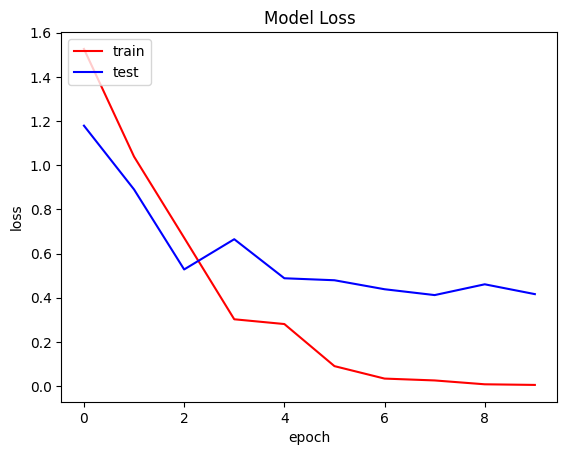

In [ ]:
plt.plot(history.history['loss'], color = 'red')
plt.plot(history.history['val_loss'], color = 'blue')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()